# Heart Disease UCI - Classifications

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

data = pd.read_csv('../input/heart.csv')
data.head()

['heart.csv']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Normalization effect
We are going to see the normalization effect on the age variable.

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


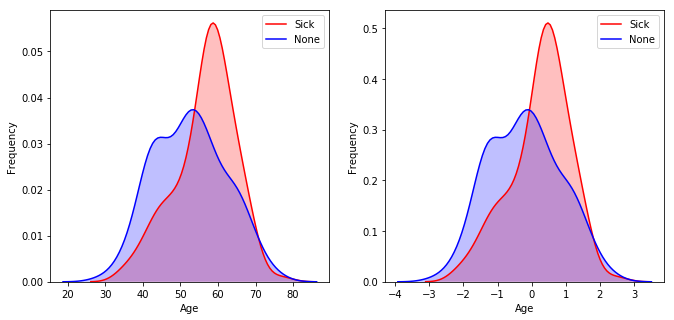

In [2]:
import seaborn as sns
import pandas as pd

dims = (11, 5)
fig, ax = plt.subplots(1,2, figsize=dims)

g = sns.kdeplot(data["age"][(data["target"] == 0) & (data["age"].notnull())], ax =ax[0], color="Red", shade = True)
g = sns.kdeplot(data["age"][(data["target"] == 1) & (data["age"].notnull())], ax =ax[0], color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Sick","None"])


average = data["age"].mean()
std = data["age"].std()
age_normalized = (data["age"] - average) / std

h = sns.kdeplot(age_normalized[(data["target"] == 0) & (age_normalized.notnull())], ax =ax[1], color="Red", shade = True)
h = sns.kdeplot(age_normalized[(data["target"] == 1) & (age_normalized.notnull())], ax =ax[1], color="Blue", shade= True)
h.set_xlabel("Age")
h.set_ylabel("Frequency")
h = h.legend(["Sick","None"])

fig.show()

As you can see normalization with Z-score change the value of our variable but keep the distribution of our data.

## Transformation of our data and creation of our pipeline

Now, we are going to create our pipeline which will take our data and apply transformations on it. We are going to use One-Hot encoding and Z-score normalization on our data.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

# Use One-Hot Encoding
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["sex", "fbs", "exang", "cp", "restecg", "slope", "ca", "thal"])),
        ("cat_encoder", OneHotEncoder(sparse=False, categories='auto')),
    ])

# Use Z-score normalization
standard_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["age", "trestbps", "chol", "thalach", "oldpeak"])),
        ('scale', StandardScaler()),
    ])

# Merge pipelines
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("standard_pipeline", standard_pipeline),
    ])

In [4]:
# Get the target value
target = np.array(data["target"].values)
data.drop('target', axis=1, inplace=True)

# Use our pipeline on our data
data = preprocess_pipeline.fit_transform(data)

# Split our data in train and test samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=42)

In [5]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)



## Classification systems

### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, max_depth=5)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8096086956521737

In [7]:
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)

Confusion matrix, without normalization
[[25  4]
 [ 3 29]]


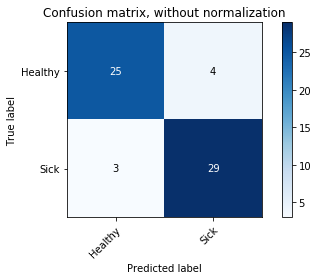

Accuracy
0.8858225108225108
Recall
0.8841594827586207


In [8]:
from sklearn.metrics import confusion_matrix

class_names = np.array(["Healthy", "Sick"])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

from sklearn.metrics import precision_score
print ("Accuracy")
print(precision_score(y_test, y_pred, average='macro'))

from sklearn.metrics import recall_score
print ("Recall")
print(recall_score(y_test, y_pred, average='macro'))

## Support-vector machine

0.8219420289855071
Accuracy
0.9021505376344086
Recall
0.9030172413793103
Confusion matrix, without normalization
[[27  2]
 [ 4 28]]


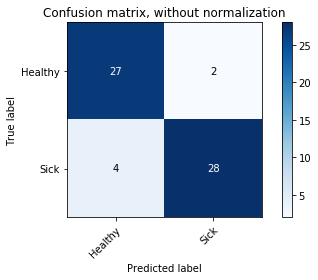

In [9]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print(svm_scores.mean())

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

print ("Accuracy")
print(precision_score(y_test, y_pred, average='macro'))

print ("Recall")
print(recall_score(y_test, y_pred, average='macro'))


# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## K-nearest neighbors

0.7927608695652174
Accuracy
0.8858225108225108
Recall
0.8841594827586207
Confusion matrix, without normalization
[[25  4]
 [ 3 29]]


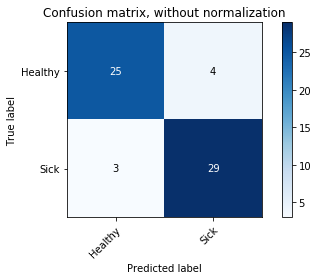

In [10]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(X_train, y_train)
neigh_scores = cross_val_score(neigh, X_train, y_train, cv=10)
print(neigh_scores.mean())

neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print ("Accuracy")
print(precision_score(y_test, y_pred, average='macro'))

print ("Recall")
print(recall_score(y_test, y_pred, average='macro'))

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## Compare the different systems based on the recall

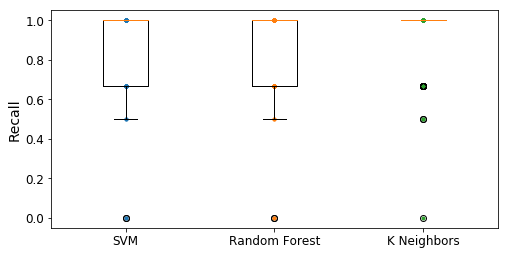

In [11]:
prm = 50

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=prm, scoring='recall')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=prm, scoring='recall')
neigh_scores = cross_val_score(neigh, X_train, y_train, cv=prm, scoring='recall')

%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.figure(figsize=(8, 4))
plt.plot([1]*prm, svm_scores, ".")
plt.plot([2]*prm, forest_scores, ".")
plt.plot([3]*prm, neigh_scores, ".")
plt.boxplot([svm_scores, forest_scores, neigh_scores], labels=("SVM","Random Forest", "K Neighbors"))
plt.ylabel("Recall", fontsize=14)
plt.show()